[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0087DeepLearningConv2DFashionMNIST.ipynb)

In [3]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchmetrics.classification import MulticlassAccuracy
import torchvision

# Miscellaneous
import math
import os
from platform import python_version
import random
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

import pytest
import nibabel as nib
import os
from nibabel.testing import data_path
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset



In [45]:
img_types = ['t1','t1ce','t2','flair','seg']

In [55]:

def get_sample(sample_path):
    file_extension = ['_t1.','_t1ce.','_t2.','_flair.','_seg.']
    title = ['t1','t1ce','t2','flair','seg']
    img = np.zeros(IMG_SIZE*5)
    img = img.reshape(5,240,240,155)


    files = os.listdir(sample_path)
    for ext in file_extension:
     for file in files:
       if ext in file and ext == '_t1.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[0] = im
       if ext in file and ext == '_t1ce.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[1] = im
       if ext in file and ext == '_t2.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[2] = im
       if ext in file and ext == '_flair.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[3] = im
       if ext in file and ext == '_seg.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[4] = im
          
    return img
  
  
def get_number_of_samples(root_path,sample_type)  :
   files = os.listdir(root_path)
   no_of_samples = 0
   for file_name in files:
     if os.path.isdir(root_path +file_name):
      no_of_samples+= len(os.listdir(root_path + file_name +'/'+sample_type+'/'))
   return no_of_samples
     
def get_file_names_by_type(root_path,sample_type):
   files = os.listdir(root_path)
   t1_files =[]
   t1ce_files=[]
   t2_files =[]
   flair_files=[]
   seg_files=[]
   file_list = []
   
   for file_name in files:
     if os.path.isdir(root_path +file_name):
      hgg_dirs = os.listdir(root_path + file_name +'/'+sample_type+'/')
      for nii_dir in hgg_dirs:
        if os.path.isdir(root_path + file_name +'/'+sample_type+'/'+nii_dir):
           nii_files = os.listdir(root_path + file_name +'/'+sample_type+'/'+nii_dir)
           local_dir = root_path + file_name +'/'+sample_type+'/'+nii_dir+'/'
           for file in nii_files:
            if '_t1.' in file: 
               t1_files.append(local_dir+file)
            if '_t1ce.' in file: 
               t1ce_files.append(local_dir+file)
            if '_t2.' in file: 
               t2_files.append(local_dir+file)
            if '_flair.' in file: 
               flair_files.append(local_dir+file)
            if '_seg.' in file: 
               seg_files.append(local_dir+file)
   file_list.append(t1_files)
   file_list.append(t1ce_files)
   file_list.append(t2_files)
   file_list.append(flair_files)
   file_list.append(seg_files)
   return file_list

def print_sample(sample_path):
  file_extension = ['_t1','_t1ce','_t2','_flair','_seg']
  title = ['t1','t1ce','t2','flair','seg']
  img = np.zeros(IMG_SIZE*5)
  img = img.reshape(5,240,240,155)
  
  img = get_sample(sample_path)

  fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize = (12, 6))
  ax_all = (ax1,ax2,ax3,ax4,ax5)

  i=0
  for ax in ax_all:
    ax.imshow(img[i][img[i].shape[0]//2])
    ax.set_title(title[i])
    i+=1

def show_img(img):
   fig, ax = plt.subplots(1,1, figsize = (12, 6))
   ax.imshow(img[img.shape[0]//2])
   
def load_samples_by_type(root_path,sample_type):
     numSamplesTrain = get_number_of_samples(root_path,sample_type)
     array_size = np.int64(IMG_SIZE*5*numSamplesTrain)
     mTrain = torch.zeros(array_size)
     mTrain = torch.reshape(mTrain,(numSamplesTrain,5,240,240,155))
     
     for i in range(numSamplesTrain):
        mTrain[i] = get_sample(root_path,sample_type)
   
     return mTrain
     
     
     



In [47]:
class ImageDataset(Dataset):
    def __init__(self, img_dir,type_of_bc, img_type, transform=None, target_transform=None):
        self.all_files = get_file_names_by_type(img_dir,type_of_bc)
        self.type_of_bc = type_of_bc
        self.img_labels = self.all_files[4]
        self.img_dir = img_dir
        self.img_type_idx = img_types.index(img_type)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return get_number_of_samples(self.img_dir,self.type_of_bc)

    def __getitem__(self, idx):
        
        image = np.zeros(IMG_SIZE)
        image = image.reshape(240,240,155)
        image = nib.load(self.all_files[self.img_type_idx][idx]).get_fdata()
          
        label = np.zeros(IMG_SIZE)
        label = label.reshape(240,240,155)
        label = nib.load(self.all_files[4][idx]).get_fdata()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

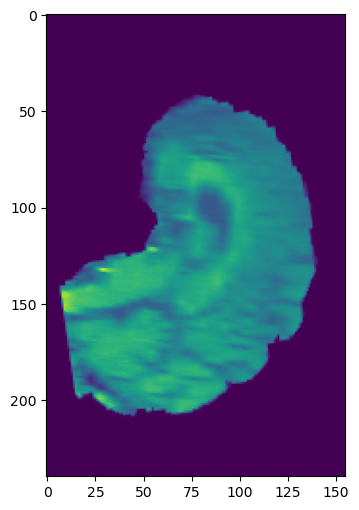

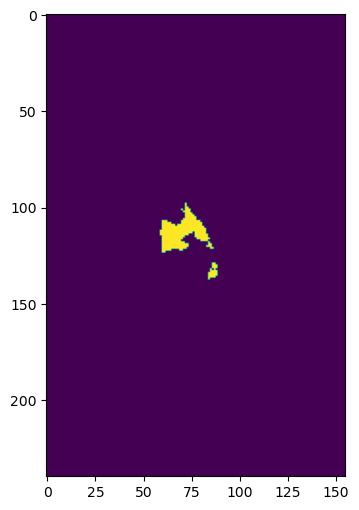

In [57]:
dsT1Train = ImageDataset('/Users/ronenrayten/Downloads/archive/','HGG','t1')
train_dataloader = torch.utils.data.DataLoader(dsT1Train, batch_size=10, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

show_img(train_features[0])
show_img(train_labels[0])

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [ ]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False


In [15]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2
IMG_SIZE = 240*240*155

D_CLASSES_FASHION_MNIST = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Boots'}
L_CLASSES_FASHION_MNIST = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boots']

T_IMG_SIZE_MNIST = (28, 28)

DATA_FOLDER_PATH    = 'Data'
TENSOR_BOARD_BASE   = 'TB'


In [ ]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [ ]:
# Courses Packages

from DataVisualization import PlotLabelsHistogram, PlotMnistImages
from DeepLearningPyTorch import TrainModel


In [ ]:
# General Auxiliary Functions


## Brain Tumor Image Classification using DL




In [ ]:
# Parameters

# Data
numSamplesTrain = 60
numSamplesTest  = 160

# Model
dropP = 0.2 #<! Dropout Layer

# Training
batchSize   = 10
numWork     = 2 #<! Number of workers
nEpochs     = 30

# Visualization
numImg = 3



## Generate / Load Data

Load the [Fashion MNIST Data Set](https://github.com/zalandoresearch/fashion-mnist).  

The _Fashion MNIST Data Set_ is considerably more challenging than the original MNIST though it is still no match to Deep Learning models.

* <font color='brown'>(**#**)</font> The data set is available at [OpenML - Fashion MNIST](https://www.openml.org/search?type=data&id=40996).  
  Yet it is not separated into the original _test_ and _train_ sets.

In [ ]:
# Load Data

mX, vY = fetch_openml('Fashion-MNIST', version = 1, return_X_y = True, as_frame = False, parser = 'auto')
vY = vY.astype(np.int_) #<! The labels are strings, convert to integer

print(f'The features data shape: {mX.shape}')
print(f'The labels data shape: {vY.shape}')
print(f'The unique values of the labels: {np.unique(vY)}')

* <font color='brown'>(**#**)</font> The images are grayscale with size `28x28`.

In [ ]:
# Pre Process Data

mX = mX / 255.0

* <font color='red'>(**?**)</font> Does the scaling affects the standardization (Zero mean, Unit variance) process?

### Plot the Data

In [ ]:
# Plot the Data

hF = PlotMnistImages(mX, vY, numImg)
plt.show()

In [ ]:
# Histogram of Labels

hA = PlotLabelsHistogram(vY, lClass = L_CLASSES_FASHION_MNIST)
plt.show()

## Train & Test Split

In [ ]:
# Train Test Split

numClass = len(np.unique(vY))

#===========================Fill This===========================#
# 1. Split the data into train and test (Validation) data sets (NumPy arrays).
# 2. Use stratified split.
# !! The output should be: `mXTrain`, `mXTest`, `vYTrain`, `vYTest`.
mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = numSamplesTest, train_size = numSamplesTrain, shuffle = True, stratify = vY)
#===============================================================#

print(f'The training features data shape: {mXTrain.shape}')
print(f'The training labels data shape: {vYTrain.shape}')
print(f'The test features data shape: {mXTest.shape}')
print(f'The test labels data shape: {vYTest.shape}')
print(f'The unique values of the labels: {np.unique(vY)}')

In [ ]:
# Torch Datasets

#===========================Fill This===========================#
# 1. Convert the arrays to the 2D shape as needed.
# 2. Generate Torch data sets from the NumPy arrays.
# !! The output should be: `dsTrain`, `dsTest`.
# !! Verify the number of channels is well defined.
# !! The `T_IMG_SIZE_MNIST` tuple might be useful.
# !! The `torch.utils.data.TensorDataset` class might be useful.
# !! Pay attention to the type of the data as tensors.
dsTrain = torch.utils.data.TensorDataset(torch.tensor(np.reshape(mXTrain, (numSamplesTrain, 1, *T_IMG_SIZE_MNIST)), dtype = torch.float32), torch.tensor(vYTrain, dtype = torch.long))
dsTest  = torch.utils.data.TensorDataset(torch.tensor(np.reshape(mXTest, (numSamplesTest, 1, *T_IMG_SIZE_MNIST)), dtype = torch.float32), torch.tensor(vYTest, dtype = torch.long))
#===============================================================#

print(f'The training data set data shape: {(len(dsTrain), *dsTrain.tensors[0].shape[1:])}')
print(f'The test data set data shape: {(len(dsTest), *dsTrain.tensors[0].shape[1:])}')

## Pre Process Data

This section normalizes the data to have zero mean and unit variance per **channel**.  
It is required to calculate:

 * The average pixel value per channel.
 * The standard deviation per channel.

In [ ]:
# Calculate the Standardization Parameters

#===========================Fill This===========================#
# 1. Calculate the mean per channel.
# 2. Calculate the standard deviation per channel.
µ = torch.mean(dsTrain.tensors[0])
σ = torch.std(dsTrain.tensors[0])
#===============================================================#

print('µ =', µ)
print('σ =', σ)

In [ ]:
# Update Transformer

#===========================Fill This===========================#
# 1. Define a transformer which normalizes the data.
# 2. Update the `transform` object in `dsTrain` and `dsTest`.
oDataTrns = torchvision.transforms.Compose([  #<! Chaining transformations
    torchvision.transforms.ToTensor(),        #<! Convert to Tensor (C x H x W), Normalizes into [0, 1] (https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)
    torchvision.transforms.Normalize(µ, σ),   #<! Normalizes the Data (https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)
    ])

# Update the DS transformer
dsTrain.transform = oDataTrns
dsTest.transform  = oDataTrns
#===============================================================#


In [ ]:
# "Normalized" Image

mX, valY = dsTrain[5]

hF, hA = plt.subplots()
hA.imshow(np.transpose(mX, (1, 2, 0)))
plt.show()

### Data Loaders

The dataloader is the functionality which loads the data into memory in batches.  
Its challenge is to bring data fast enough so the Hard Disk is not the training bottleneck.  
In order to achieve that, Multi Threading / Multi Process is used.


In [ ]:
# Data Loader

#===========================Fill This===========================#
# 1. Create the train data loader.
# 2. Create the test data loader.
# !! Think about the values of `shuffle` and `batch_size` for the train / test.
dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWork, persistent_workers = True)
dlTest   = torch.utils.data.DataLoader(dsTest, shuffle = False, batch_size = 2 * batchSize, num_workers = numWork, persistent_workers = True)
#===============================================================#


In [ ]:
# Iterate on the Loader
# The first batch.
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

## Define the Model

This section build 3 different models to be evaluated.

In [ ]:
# Model Container
lModels = []

In [ ]:
# Model
# Defining a sequential model.

oModel = nn.Sequential(
#===========================Fill This===========================#
# 1. Create the 1st model.
# 2. Use 3 layers.
# !! You may use different kernel size, dropout probability, max pooling, etc...

    nn.Identity(),
    
    nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 3, bias = False),
    nn.BatchNorm2d(num_features = 30),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 3, bias = False),
    nn.MaxPool2d(kernel_size = 2),
    nn.BatchNorm2d(num_features = 60),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
            
    nn.Conv2d(in_channels = 60,  out_channels = 120, kernel_size = 3, bias = False),
    nn.MaxPool2d(kernel_size = 2),
    nn.BatchNorm2d(num_features = 120),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(120, len(L_CLASSES_FASHION_MNIST)),
#===============================================================#
)

print(torchinfo.summary(oModel, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')) #<! Added `kernel_size`

# Append Model
lModels.append(oModel)

In [ ]:
# Model
# Defining a sequential model.

oModel = nn.Sequential(
#===========================Fill This===========================#
# 1. Create the 2nd model.
# 2. Use 3 layers.
# !! You may use different kernel size, dropout probability, max pooling, etc...

    nn.Identity(),
    
    nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 5, bias = False),
    nn.BatchNorm2d(num_features = 30),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 5, bias = False),
    nn.BatchNorm2d(num_features = 60),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
            
    nn.Conv2d(in_channels = 60,  out_channels = 120, kernel_size = 5, bias = False),
    nn.BatchNorm2d(num_features = 120),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(120, len(L_CLASSES_FASHION_MNIST)),
#===============================================================#
)

print(torchinfo.summary(oModel, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')) #<! Added `kernel_size`

# Append Model
lModels.append(oModel)

In [ ]:
# Model
# Defining a sequential model.

oModel = nn.Sequential(
#===========================Fill This===========================#
# 1. Create the 3rd model.
# 2. Use 3 layers.
# !! You may use different kernel size, dropout probability, max pooling, etc...

    nn.Identity(),
    
    nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 7, bias = False),
    nn.MaxPool2d(kernel_size = 2),
    nn.BatchNorm2d(num_features = 30),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 5, bias = False),
    nn.MaxPool2d(kernel_size = 2),
    nn.BatchNorm2d(num_features = 60),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
            
    nn.Conv2d(in_channels = 60,  out_channels = 120, kernel_size = 3, bias = False),
    nn.BatchNorm2d(num_features = 120),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(120, len(L_CLASSES_FASHION_MNIST)),
#===============================================================#
)

print(torchinfo.summary(oModel, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')) #<! Added `kernel_size`

# Append Model
lModels.append(oModel)

* <font color='brown'>(**#**)</font> Guideline: The smaller the image gets, the deeper it is (More channels).   
  The intuition, the beginning of the model learns low level features (Small number), deeper learns combinations of features (Larger number).

## Training Loop


### Train the Model

In [ ]:
# Check GPU Availability

runDevice   = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device


In [ ]:
# Set the Loss & Score

#===========================Fill This===========================#
# 1. Define loss function
# 2. Define score function.
hL = nn.CrossEntropyLoss()
hS = MulticlassAccuracy(num_classes = len(L_CLASSES_FASHION_MNIST))
hL = hL.to(runDevice) #<! Not required!
hS = hS.to(runDevice)
#===============================================================#

In [ ]:
# Train the Model

#===========================Fill This===========================#
# 1. Build a loop to evaluate all models.
# 2. Define a TensorBoard Writer per model to keep its score.
# !! You may use `TrainModel()`.

for ii, oModel in enumerate(lModels):
    # Hyper Parameter Loop
    oTBWriter = SummaryWriter(log_dir = os.path.join(TENSOR_BOARD_BASE, f'Model{(ii + 1):03d}'))
    oModel = oModel.to(runDevice) #<! Transfer model to device
    oOpt = torch.optim.AdamW(oModel.parameters(), lr = 6e-4, betas = (0.9, 0.99), weight_decay = 1e-3) #<! Define optimizer
    oRunModel, lTrainLoss, lTrainScore, lValLoss, lValScore = TrainModel(oModel, dlTrain, dlTest, oOpt, nEpochs, hL, hS, oTBWriter)
    oTBWriter.close()
#===============================================================#

* <font color='brown'>(**#**)</font> Run `tensorboard --logdir=TB` from the Jupyter notebook path.
* <font color='green'>(**@**)</font> Optimize the model search to get above 92% accuracy in validation set.